## Вероятность взять n карт, эмпирически
Используем принцип Монте-Карло, считая большое число раз количество ходов (СКХ), которые нужны для того, чтобы взять n карт заданного цвета при разном варианте подсчёта. Только 1 игрок. Карты берутся случайно.

In [67]:
import random as rd
import numpy as np

def get_vagon(deck) -> (str, int):
    deck_names = ["green", "blue", "white", "yellow", "red", "black", "pink", "orange", "locomotive"]
    Vagons_in_deck = np.sum(deck)
    num = rd.randint(0,Vagons_in_deck-1)
#     print(Vagons_in_deck, num)
    for i in range(len(deck)):
#         print(i, deck, num)
        num -= deck[i]
        if num <= 0: 
#             print(i, deck_names[i])
            deck[i] -=1
            return deck_names[i], i
    
def check_count(need_type, need_cnt, hand) -> bool:
    deck_names = {"green":0, "blue":1, "white":2, "yellow":3, "red":4, "black":5, "pink":6, "orange":7, "locomotive":8}
    if need_type != "gray": 
        type_idx = deck_names[need_type]
        return need_cnt <= hand[type_idx] + hand[deck_names["locomotive"]]
    else:
        ans = False
        for i in range(8):
            if need_cnt <= hand[i] + hand[deck_names["locomotive"]]: ans = True
        return ans
    
    
def count_turns(need_type = "gray", need_cnt = 1, cards_per_turn = 2) -> float:
#     deck = {"green":12, "blue":12, "white":12, "yellow":12, "red":12, "black":12, "pink":12, "orange":12, "locomotive":14}
    deck_l = [12,12,12,12,12,12,12,12,14] #green, blue, white, yellow, red, black, pink, orange, locomotive
#     hand = {"green":0, "blue":0, "white":0, "yellow":0, "red":0, "black":0, "pink":0, "orange":0, "locomotive":0}
    hand_l = [0 for _ in range(9)] #green, blue, white, yellow, red, black, pink, orange, locomotive
    turns = 0
    
    while not check_count(need_type, need_cnt, hand_l):
        turns += 1
        for i in range(cards_per_turn):
            vagon_type, clr_idx = get_vagon(deck_l)
            hand_l[clr_idx] +=1
    
#     print(deck_l, hand_l)
    return turns


### Вот тут можно выбрать любой перегон и посчитать для него СКХ
need_type - цвет перегона, на английском ("green", "blue", "white", "yellow", "red", "black", "pink", "orange", "gray")\
need_cnt - длина рассматриваемого перегона\
NOL - количество прогонов случая\
CPT - количество карт, которые берутся в ход.\
PB - Показ статуса подсчёта 

In [68]:
%%time

#Parametrs
need_type = "green"
need_cnt = 3
NOL = 2 * 10**4
CPT = 2
PB = True


#Code
if NOL<100: PB = False


def Turns_for_road(need_type, need_cnt, ProgressBar = PB, Num_of_launches = NOL) -> float:
    turns = np.array(())

    for i in range(Num_of_launches):
        if ProgressBar: 
            if (i+1)%(Num_of_launches//10) == 0: print((i+1)//(Num_of_launches//100), end = " ")
        ct = count_turns(need_type, need_cnt, cards_per_turn = CPT)
        turns = np.append(turns, ct)
    
    if ProgressBar: print("\n")
    return np.average(turns)

print(Turns_for_road(need_type, need_cnt, Num_of_launches=NOL))

10 20 30 40 50 60 70 80 90 100 

6.42305
Wall time: 4.42 s


### А тут считаются все возможные перегоны и записываются в файл.
NOL - Количество прогонов каждого случая \
Accuracy - Количество знаков после запятой в ответе \
CPT - Количество карта, которые берутся в ход 

In [26]:
%%time

#Parametrs
NOL = 2 * 10**4 # количество прогонов каждого случая
Accuracy = 4 # количество знаков после запятой
CPT = 2 # количество карт, которые берутся в ход.

#Code
fout = open(f"TtR_ANoT_{NOL}.txt", "w") # Average number of turns
colors = ("green", "blue", "white", "yellow", "red", "black", "pink", "orange", "gray")
Acc = 10**Accuracy
ANoT = np.array([0 for _ in range(56)], dtype=float).reshape(8,7) # h - color; w - len

fout.write(f"Average number of turns\nTable: No\nPlayers: 1\nNum_of_launches: {NOL}\n"\
           f"Accuracy: {Accuracy}\nCards per turn: {CPT}\n\n")
for clr_idx, clr in enumerate(colors):
    fout.write(f'{clr}\n')
    print(clr)
    for cnt in range(1,8):
        turns = int(Turns_for_road(clr, cnt, ProgressBar=False, Num_of_launches = NOL)*Acc)/Acc
        if clr_idx !=8: ANoT[clr_idx][cnt-1] = turns
        fout.write(f'{cnt}: {turns}\n')

fout.write("\nAverages of colors\n")
# print(ANoT)
avg = np.mean(ANoT, axis=0)
for cnt in range(7):
#     print(int(avg[cnt]*Acc)/Acc)
    fout.write(f'{cnt+1}: {int(avg[cnt]*Acc)/Acc}\n')
    
fout.close()

green
blue
white
yellow
red
black
pink
orange
gray
Wall time: 4min 47s


## Ну теперь добавим на стол 5 карт.
Карты берутся уже с учётом того, что есть 5 карт на столе. Только 1 игрок.

In [84]:
import random as rd
from numpy import random as nrd
import numpy as np
import matplotlib.pyplot as plt

deck_names = {"green":0, "blue":1, "white":2, "yellow":3, "red":4, "black":5, "pink":6, "orange":7, "locomotive":8}
deck_names_inv = ["green", "blue", "white", "yellow", "red", "black", "pink", "orange", "locomotive", "gray"]

def get_vagon_from_deck(deck, target) -> None:
    Vagons_in_deck = np.sum(deck)
    num = rd.randint(0,Vagons_in_deck-1)

    for i in range(len(deck)):
        num -= deck[i]
        if num < 0: 
            deck[i] -=1
            target[i] +=1
            return


def count_type_on_table(need_type, table) -> int:
    try:
        return table[deck_names[need_type]]
    except:
        return 0
    

def count_type_colleced(need_type, hand) -> int:
    if need_type != "gray": 
        type_idx = deck_names[need_type]
        return hand[type_idx] + hand[deck_names["locomotive"]]
    
    else:
        max_cnt = 0
        for i in range(8):
            if max_cnt < hand[i] + hand[deck_names["locomotive"]]: max_cnt = hand[i] + hand[deck_names["locomotive"]]
        return max_cnt
    
    
def get_vagon_from_table(deck, hand, table, need_type) -> None:
    table[deck_names[need_type]] -=1
    hand[deck_names[need_type]] +=1
    refresh_table(deck, table)
        
    return 


def refresh_table(deck, table) -> None:
    while np.sum(table) != 5:
        get_vagon_from_deck(deck, table)
        if count_type_on_table("locomotive", table) == 3:
            table = [0 for _ in range(9)]
    
    

def count_turns_table(need_type = "gray", need_cnt = 1, cards_per_turn = 2, locomotive_strategy = "never") -> float:
    deck = [12,12,12,12,12,12,12,12,14] #green, blue, white, yellow, red, black, pink, orange, locomotive
    hand = [0 for _ in range(9)] 
#     table = [get_vagon_from_deck(deck)[0] for _ in range(5)]
    table = [0 for _ in range(9)]
    refresh_table(deck, table)
    turns = 0
    
    if need_type != "gray":
        while count_type_colleced(need_type, hand) < need_cnt:
            turns += 1
            for i in range(cards_per_turn):
                if count_type_on_table(need_type, table)>0:
                    get_vagon_from_table(deck, hand, table, need_type)
                    continue

                if locomotive_strategy == "weak":
                    if (cards_per_turn-i>0) and (count_type_on_table("locomotive", table))\
                    and count_type_colleced(need_type, hand)+1 == need_cnt:
                        get_vagon_from_table(deck, hand, table, "locomotive")
                        continue

                elif locomotive_strategy == "strong":
                    if (cards_per_turn-i>0) and (count_type_on_table("locomotive", table)):
                        get_vagon_from_table(deck, hand, table, "locomotive")
                        continue

                get_vagon_from_deck(deck, hand)
    
    else:
        while count_type_colleced(need_type, hand) < need_cnt:
            turns += 1
            for i in range(cards_per_turn):
                if need_type == "gray":
                    check_type = deck_names_inv[np.argmax(hand)]

                if count_type_on_table(check_type, table)>0:
                    get_vagon_from_table(deck, hand, table, check_type)
                    continue

                if locomotive_strategy == "weak":
                    if (cards_per_turn-i>0) and (count_type_on_table("locomotive", table))\
                    and count_type_colleced(need_type, hand)+1 == need_cnt:
                        get_vagon_from_table(deck, hand, table, "locomotive")
                        continue

                elif locomotive_strategy == "strong":
                    if (cards_per_turn-i>0) and (count_type_on_table("locomotive", table)):
                        get_vagon_from_table(deck, hand, table, "locomotive")
                        continue

                get_vagon_from_deck(deck, hand)
    
   
    
    return turns


### СКХ для любого перегона, стол есть
need_type - цвет перегона, на английском ("green", "blue", "white", "yellow", "red", "black", "pink", "orange", "gray")\
need_cnt - длина рассматриваемого перегона\
Num_of_launches - количество прогонов случая\
CPT - количество карт, которые берутся в ход.\
ProgressBar - Показ статуса подсчёта\
Get_Locomotives - будем ли мы брать локомотивы со стола ("never", "weak", "strong")\
    - never - вообще не берём локомотивы со стола\
    - weak - берём локомотив со стола только если он завершает наш набор\
    - strong - берём локомотив со стола, если там нет вагона нужного цвета

In [85]:
%%time

#Parametrs
need_type = "blue"
need_cnt = 4
Num_of_launches = 2 * 10**4
CPT = 2
ProgressBar = True
Get_Locomotives = "weak"

#Code
NOL = Num_of_launches
PB = ProgressBar
if NOL<100: PB = False
GL = Get_Locomotives

# fig, m_axs = plt.subplots(1, 2, figsize=(8.4*2, 1*1.8*2), constrained_layout=False)

def Turns_for_road_table(need_type, need_cnt, ProgressBar = PB, Num_of_launches = NOL,\
                         cards_per_turn = CPT, Get_Locomotives = GL) -> float:
    turns = np.empty((Num_of_launches))

    for i in range(Num_of_launches):
        if ProgressBar: 
            if (i+1)%(Num_of_launches//10) == 0: print((i+1)//(Num_of_launches//100), end = " ")
        ct = count_turns_table(need_type, need_cnt, cards_per_turn, Get_Locomotives)
        turns[i] = ct
    
    if ProgressBar: print("\n")
        
#     fig, m_axs = plt.subplots(1, 1, figsize=(18, 7))   
#     m_axs.plot(np.linspace(0,Num_of_launches-1,Num_of_launches),turns)
#     plt.show()
    
    return np.average(turns)

print(Turns_for_road_table(need_type, need_cnt, Num_of_launches=NOL))


10 20 30 40 50 60 70 80 90 100 

6.60505
Wall time: 6.7 s


### А тут считаются все возможные перегоны и записываются в файл.
NOL - Количество прогонов каждого случая \
Accuracy - Количество знаков после запятой в ответе \
CPT - Количество карта, которые берутся в ход\
Get_locomotives - стратегия, по которой мы берём локомотивы\
    - never - вообще не берём локомотивы со стола\
    - weak - берём локомотив со стола только если он завершает наш набор\
    - strong - берём локомотив со стола, если там нет вагона нужного цвета

In [105]:
%%time

#Parametrs
Num_of_launches = 2 * 10**4 # количество прогонов каждого случая
Accuracy = 4 # количество знаков после запятой
CPT = 2 # количество карт, которые берутся в ход.
Get_Locomotives = "strong"


#Code
GT = Get_Locomotives
NOL = Num_of_launches
fout = open(f"ANoT_{NOL}_{CPT}_{GT}.txt", "w") # Average number of turns
colors = ("green", "blue", "white", "yellow", "red", "black", "pink", "orange", "gray")
Acc = 10**Accuracy
ANoT = np.array([0 for _ in range(56)], dtype=float).reshape(8,7) # h - color; w - len

fout.write(f"Average number of turns\nTable: Yes\nPlayers: 1\nNum_of_launches: {NOL}\n"\
           f"Accuracy: {Accuracy}\nCards per turn: {CPT}\nLocomotive strategy: {GT}\n\n")


for clr_idx, clr in enumerate(colors):
    fout.write(f'{clr}\n')
    print(clr)
    for cnt in range(1,8):
        turns = int(Turns_for_road_table(clr, cnt, ProgressBar=False, Num_of_launches = NOL,\
                                         cards_per_turn = CPT, Get_Locomotives = GT)*Acc)/Acc
        if clr_idx !=8: ANoT[clr_idx][cnt-1] = turns
        fout.write(f'{cnt}: {turns}\n')


fout.write("\nAverages of colors\n")
# print(ANoT)
avg = np.mean(ANoT, axis=0)
for cnt in range(7):
#     print(int(avg[cnt]*Acc)/Acc)
    fout.write(f'{cnt+1}: {int(avg[cnt]*Acc)/Acc}\n')
    
fout.close()

green
blue
white
yellow
red
black
pink
orange
gray
Wall time: 6min 24s


### Давайте сравним различные варианты политики взятия локомотивов
never - вообще не берём локомотивы со стола\
weak - берём локомотив со стола только если он завершает наш набор\
strong - берём локомотив со стола, если там нет вагона нужного цвета

never
weak
strong
[[1.4161 2.4527 3.7674 5.1661 6.5664 7.9147 9.2289]
 [1.1728 1.9459 3.1948 4.5777 5.9641 7.2867 8.688 ]
 [1.1794 1.802  2.8666 4.2477 5.5354 6.8766 8.2684]]


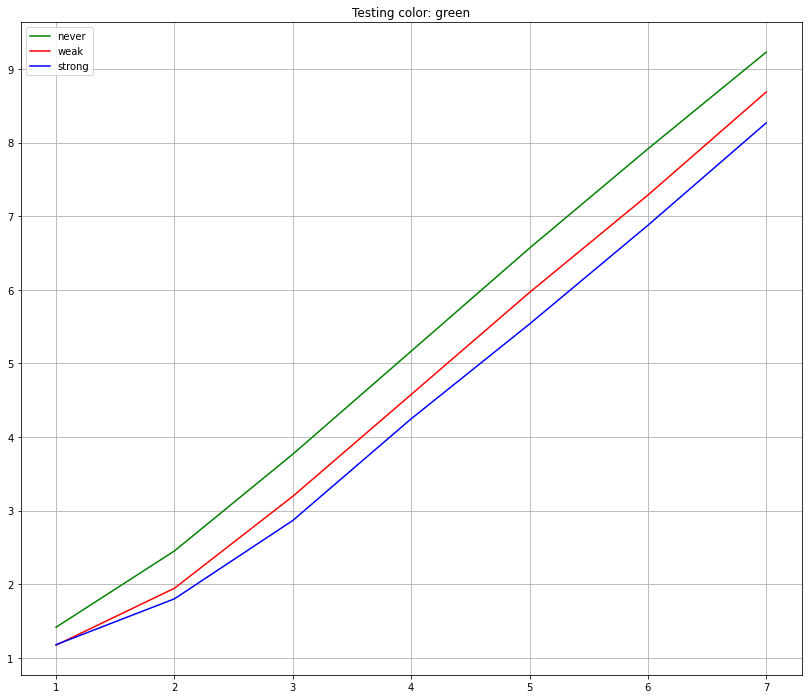

Wall time: 2min 30s


In [104]:
%%time

#Parametrs
NOL = 2 * 10**4 # количество прогонов каждого случая
Accuracy = 4 # количество знаков после запятой
CPT = 3 # количество карт, которые берутся в ход.
Max_cards = 7


#Code
clr = "green"
plot_colors = ('g', 'r', 'b')
Get_Locomotives = ("never", "weak", "strong")
Acc = 10**Accuracy
GL = Get_Locomotives
MX = Max_cards
turns_plot = np.empty((3,MX))


fig, m_axs = plt.subplots(1, 1, figsize=(14, 12)) 
plt.grid()
for loc_idx, loc_str in enumerate(GL):
    print(GL[loc_idx])
    for cnt in range(1,MX+1):
        turns_plot[loc_idx][cnt-1] = int(Turns_for_road_table\
                     (clr, cnt, ProgressBar=False, Num_of_launches = NOL,\
                      cards_per_turn = CPT, Get_Locomotives = loc_str)*Acc)/Acc

    m_axs.plot(np.linspace(1,len(turns_plot[loc_idx]),len(turns_plot[loc_idx])),turns_plot[loc_idx],\
               color = plot_colors[loc_idx], label=GL[loc_idx]) 

m_axs.set_title(f"Testing color: {clr}")
    
print(turns_plot)
plt.legend()
plt.show()

## Добавить игроков? Пфф, да легко
На самом деле это было не очень легко, тем более что модель других игроков только одна: "Simple".\
Дальше попробую что-то с этим сделать.

## Считаем стоимость маршрутов 
Дейкстрой пробегаем по маршрутам, используя в качестве весов СКХ, требуемое на перегон, вычисленное пунктом выше.